In [603]:
import json
from multiprocessing.sharedctypes import Value
from typing import List, Dict
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics

#from typeguard import typechecked
from operator import itemgetter

In [604]:
def read_json_file(json_file_name):
    json_data = pd.read_json(json_file_name)
    if 'results' in json_data:
        json_data = json_data['results']
    return(json_data)   

In [605]:
def is_jsonkey_in(json_data, json_key) -> bool:
    return( True if json_key in json_data else False)  

In [606]:
def split_json_by_file(json_data, file_name):
    return json_data[file_name]

In [607]:
def split_json_by_prepro(json_data, pre_proc_meth, HAS_KEY: bool):
    if not HAS_KEY: 
        r = (json_data[pre_proc_meth])
    else:
        # double check a key exist
        if is_jsonkey_in(json_data[pre_proc_meth][0], "results"):
             r = [ e['results'] for e in json_data[pre_proc_meth] ]
    
    return (r)

    

In [608]:
def split_json_by_classifier(json_data, classifier):
    return(json_data[classifier])

In [609]:
def split_json_by_metrics(json_data, file_, prepo_, classif_, metrics_) -> pd.DataFrame:
    t1 = []
    t2 = []
    t3 = []
    t4 = []    
    t5 = []
    t6 = []
    for x in json_data[metrics_[0]] :
        t4.append(x)
    
    for x_ in json_data[metrics_[1]]:
        t5.append(x)

    for x_ in json_data[metrics_[2]]:
        t6.append(x)
        t3.append(classif_)
        t1.append(file_)
        t2.append(prepo_)
    
    ds_ = pd.DataFrame({"ds":t1, "preproc":t2, "classifier": t3,  "acc": t4, "di": t5, "aod": t6})
    return ds_

In [610]:
def create_full_dataframe_from_json(json_file, type_of_preproc_method = ""):
    print(type_of_preproc_method)
    FILE_NAME       = ['german','adult','compas']
    PRE_PROC_METHOD = ['baseline','Reweighing','DisparateImpactRemover','OptimPreproc','LFR']
    CLASSIFIER      = ['Logistic Regression', 'Random Forest']
    METRICS         = ['accuracy', 'disparate_impact', 'average_odds_difference']

    if type_of_preproc_method == 'FAIRBOOST': PRE_PROC_METHOD = ['fairboost'] #['baseline','fairboost']
    
    # Create an empty dataframe
    ds_stats = pd.DataFrame(columns = ['ds', 'preproc', 'classifier', 'acc', 'di', 'aod'])
    #clear JSON

    json_data = read_json_file(json_file)
    index_ = 0
    for file_ in FILE_NAME: 
        json_set_by_file_name = split_json_by_file(json_data, file_)
        for prepo_ in PRE_PROC_METHOD:
            if  prepo_ == 'baseline' and type_of_preproc_method == "" :
                    json_set_by_prepoc =  split_json_by_prepro(json_set_by_file_name, prepo_, False)
            else:
                json_set_by_prepoc =  split_json_by_prepro(json_set_by_file_name, prepo_, True)

            for classif_ in CLASSIFIER:
                #print(file_, prepo_,classif_,type(json_set_by_prepoc))
                if isinstance(json_set_by_prepoc,dict):
                    json_set_by_classifier = split_json_by_classifier(json_set_by_prepoc,classif_)
                    ds_= split_json_by_metrics(json_set_by_classifier, file_, prepo_,classif_, METRICS)
                    ds_stats= pd.concat([ds_stats, ds_]) 
            
                if isinstance(json_set_by_prepoc,list): 
                    for l in json_set_by_prepoc:
                      #print(len(l))
                      x = []
                      if len(l) > 0:
                          #print(l)
                          json_set_by_classifier = split_json_by_classifier(l,classif_)
                          ds_= split_json_by_metrics(json_set_by_classifier, file_, prepo_,classif_, METRICS)
                          ds_stats= pd.concat([ds_stats, ds_])  
    return (ds_stats)  
    

In [611]:
baseline_ = create_full_dataframe_from_json('json/baseline_splits.json')
print(baseline_)


        ds   preproc           classifier       acc        di       aod
0   german  baseline  Logistic Regression  0.733333  0.656667  0.656667
1   german  baseline  Logistic Regression  0.680000  0.656667  0.656667
2   german  baseline  Logistic Regression  0.666667  0.656667  0.656667
3   german  baseline  Logistic Regression  0.670000  0.656667  0.656667
4   german  baseline  Logistic Regression  0.683333  0.656667  0.656667
..     ...       ...                  ...       ...       ...       ...
5   compas       LFR        Random Forest  1.000000  1.000000  1.000000
6   compas       LFR        Random Forest  1.000000  1.000000  1.000000
7   compas       LFR        Random Forest  1.000000  1.000000  1.000000
8   compas       LFR        Random Forest  1.000000  1.000000  1.000000
9   compas       LFR        Random Forest  1.000000  1.000000  1.000000

[300 rows x 6 columns]


In [612]:
fairboost_ = create_full_dataframe_from_json('json/fairboost_splits.json',"FAIRBOOST")
print(fairboost_)

FAIRBOOST
        ds    preproc           classifier       acc        di       aod
0    adult  fairboost  Logistic Regression  0.791715  0.790487  0.790487
1    adult  fairboost  Logistic Regression  0.788849  0.790487  0.790487
2    adult  fairboost  Logistic Regression  0.785641  0.790487  0.790487
3    adult  fairboost  Logistic Regression  0.788030  0.790487  0.790487
4    adult  fairboost  Logistic Regression  0.794786  0.790487  0.790487
..     ...        ...                  ...       ...       ...       ...
5   compas  fairboost        Random Forest  0.681187  0.638889  0.638889
6   compas  fairboost        Random Forest  0.651515  0.638889  0.638889
7   compas  fairboost        Random Forest  0.656566  0.638889  0.638889
8   compas  fairboost        Random Forest  0.655303  0.638889  0.638889
9   compas  fairboost        Random Forest  0.638889  0.638889  0.638889

[120 rows x 6 columns]


In [613]:
#https://python-graph-gallery.com/bubble-plot/
def plot_bubble(data_, ds_ , prepoc_, classifier_, title_ ='', color_="green"):
    #data_ = data_.loc[ (data_['ds'] ==  ds_)   & (data_['classifier'] == classifier_) & (data_['preproc'] == prepoc_) ]
    data_ = data_.loc[  (data_['classifier'] == classifier_) & (data_['preproc'] == prepoc_) ]
    sns.set_theme()
    # Change color with c and alpha
    plt.scatter(data_['acc'], data_['di'], s=200 , c= color_, marker="o")
    plt.xlabel("Accuracy")
    plt.ylabel("Disparate impact ")
    plt.title(title_)
    # show the graph
    plt.show()  


In [614]:
#https://python-graph-gallery.com/custom-legend-with-matplotlib
def plot_markers(data_, ds_ , prepoc_, classifier_, title_ =''):
    sns.set_theme()
    g = sns.lmplot(
        data = data_,
        x = "acc", y="di", hue="preproc",
        height=5,
    )


In [615]:
def plot_box(data_, ds_ , prepoc_, classifier_, title_ =''):
    sns.set(style="darkgrid")
    ax = sns.boxplot(x="classifier", y="acc", data=data_)
 
# Calculate number of obs per group & median to position labels
    medians = data_.groupby(['classifier'])['acc'].mean().values
    nobs = data_['classifier'].value_counts().values
    nobs = [str(x) for x in nobs.tolist()]
    nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],
                medians[tick] + 0.03,
                nobs[tick],
                horizontalalignment='center',
                size='x-small',
                color='w',
                weight='semibold')
 
    plt.show()

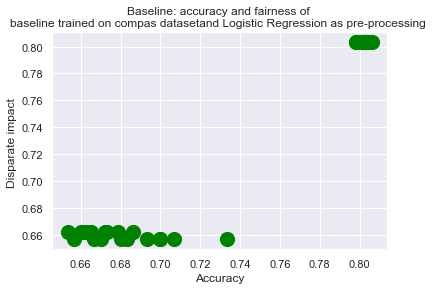

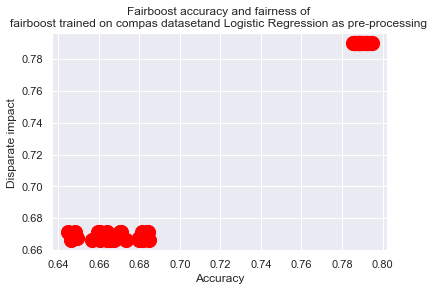

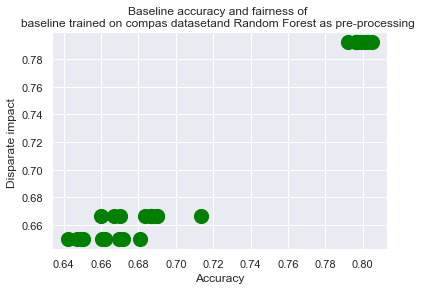

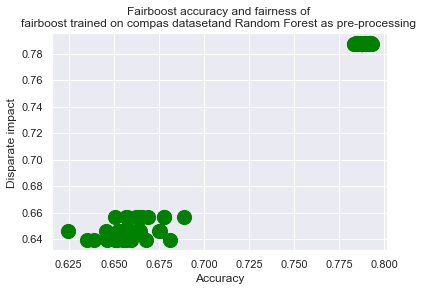

In [616]:
dataset_name = 'compas'
pre_processing = 'Logistic Regression'

classifier_name = 'baseline'
title_ = "Baseline: accuracy and fairness of \n" + \
                  classifier_name + " trained on " + dataset_name + " dataset" + "and " + pre_processing+ " as pre-processing "
plot_bubble(baseline_, dataset_name ,  classifier_name, pre_processing, title_ )


classifier_name = 'fairboost'
title_ = "Fairboost accuracy and fairness of \n" + \
                  classifier_name + " trained on " + dataset_name + " dataset" + "and " + pre_processing+ " as pre-processing "
plot_bubble(fairboost_, dataset_name ,  classifier_name, pre_processing, title_, "red" )


pre_processing = 'Random Forest'
classifier_name = 'baseline'
title_ = "Baseline accuracy and fairness of \n" + \
                  classifier_name + " trained on " + dataset_name + " dataset" + "and " + pre_processing+ " as pre-processing "
plot_bubble(baseline_, dataset_name ,  classifier_name, pre_processing, title_ )

classifier_name = 'fairboost'
title_ = "Fairboost accuracy and fairness of \n" + \
                  classifier_name + " trained on " + dataset_name + " dataset" + "and " + pre_processing+ " as pre-processing "
plot_bubble(fairboost_, dataset_name ,  classifier_name, pre_processing, title_ )



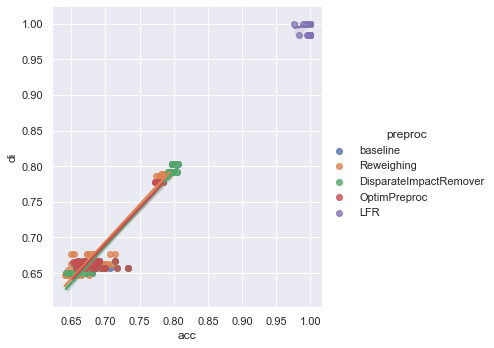

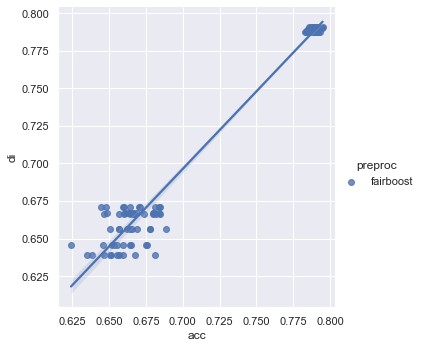

In [617]:
plot_markers(baseline_, dataset_name ,  classifier_name, pre_processing, title_ )
plot_markers(fairboost_, dataset_name ,  classifier_name, pre_processing, title_ )

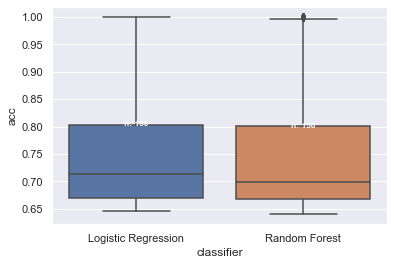

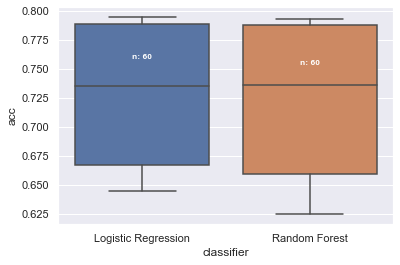

In [618]:
plot_box(baseline_, dataset_name ,  classifier_name, pre_processing, title_ )
plot_box(fairboost_, dataset_name ,  classifier_name, pre_processing, title_ )

Text(0.5, 1.0, 'Fairboost')

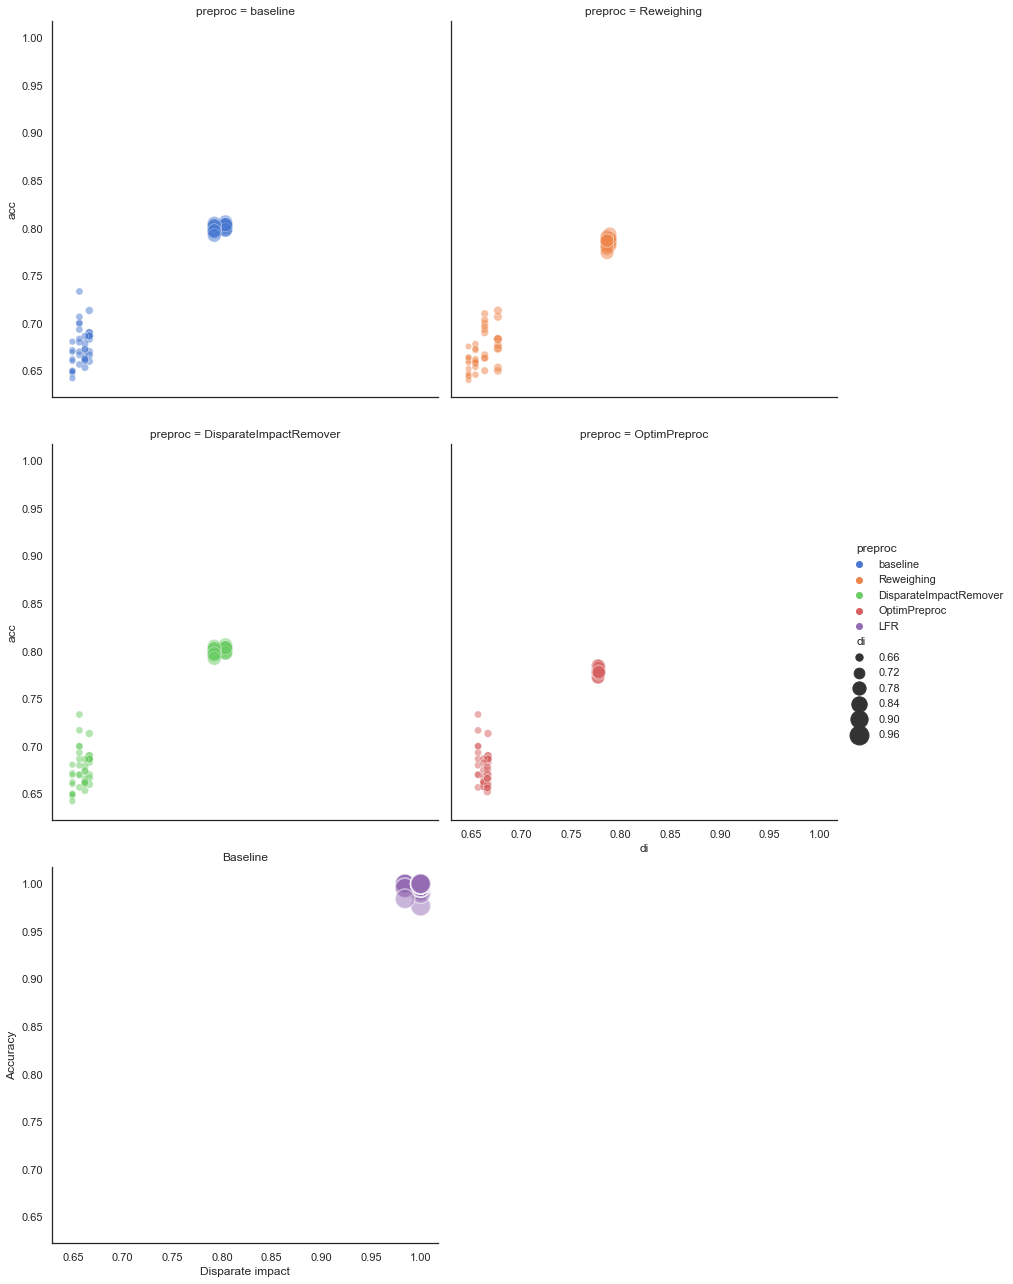

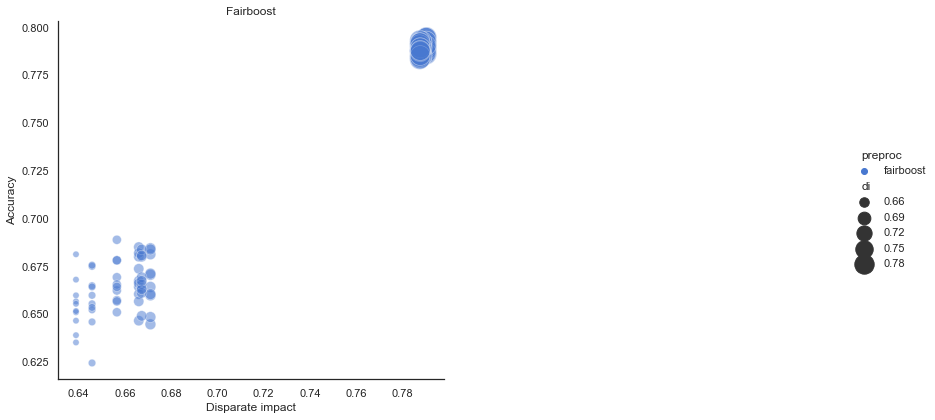

In [619]:
sns.set_theme(style="white")
PRE_PROC_METHOD = ['baseline','Reweighing','DisparateImpactRemover','OptimPreproc','LFR']
#[baseline_['preproc']==p]
#for p in PRE_PROC_METHOD:
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="di", y="acc", hue="preproc", size="di",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=baseline_, col="preproc", col_wrap=2)
plt.xlabel("Disparate impact")
plt.ylabel("Accuracy")
plt.title("Baseline")
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="di", y="acc", hue="preproc", size="di",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=fairboost_, col="preproc", col_wrap=2)
plt.xlabel("Disparate impact")
plt.ylabel("Accuracy")
plt.title("Fairboost")
